# 01-pinkify.ipynb

## Import packages

In [1]:
from pathlib import Path
import sys
# Third-party imports
import imageio as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from skimage import color, exposure, transform, util
# Custom module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import helpers

In [2]:
%load_ext autoreload
%autoreload 2

## Setup NB and load pink image

In [3]:
viewer = napari.Viewer()

In [4]:
project_dir = Path('..')
project_dir.resolve()

WindowsPath('C:/Users/gusb/projects/archipelago')

In [5]:
pink_path = Path(project_dir / 'inspiration/seashell-pink.png')
pink_path.exists()

True

In [6]:
pink_img = iio.imread(pink_path)
print(f'{pink_img.shape=}')
print(f'{pink_img.dtype=}')
print(f'{pink_img[:, :, 0].mean()=}')
print(f'{pink_img[:, :, 1].mean()=}')
print(f'{pink_img[:, :, 2].mean()=}')

pink_img.shape=(768, 1024, 3)
pink_img.dtype=dtype('uint8')
pink_img[:, :, 0].mean()=252.0
pink_img[:, :, 1].mean()=231.0
pink_img[:, :, 2].mean()=234.0


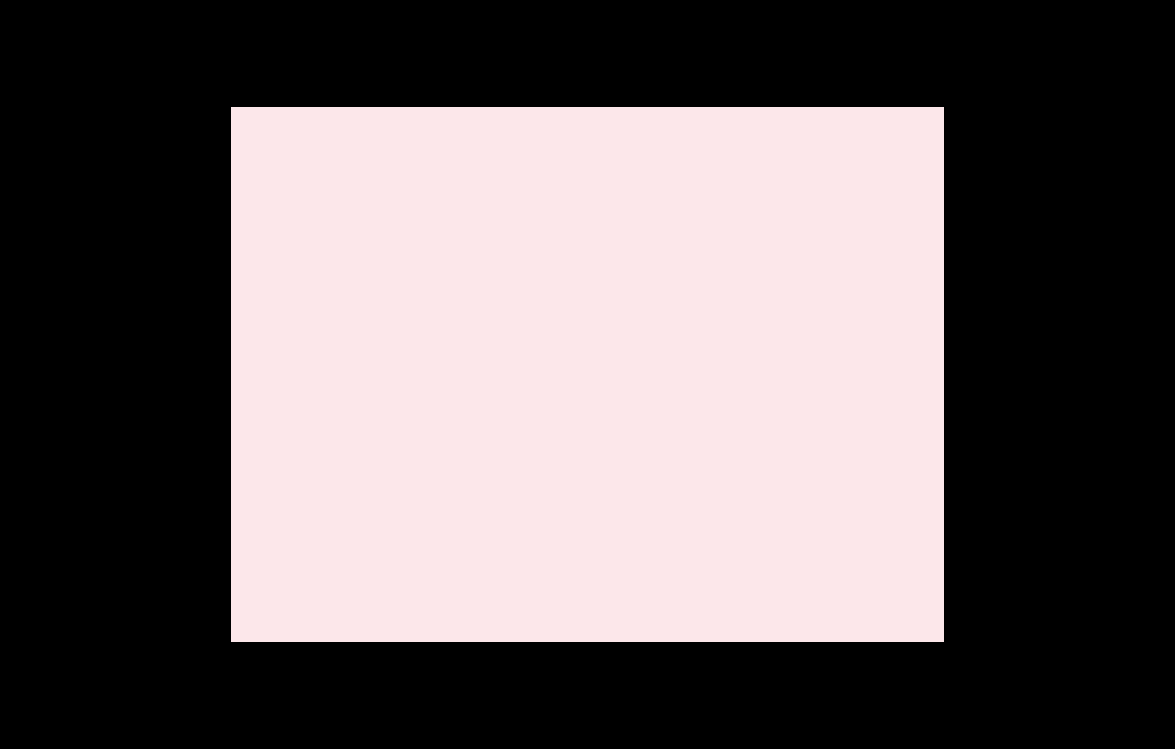

In [7]:
viewer.add_image(pink_img)
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [8]:
pink_hsv = color.rgb2hsv(pink_img)
print(f'{pink_hsv.shape=}')
print(f'{pink_hsv.dtype=}')

pink_hsv.shape=(768, 1024, 3)
pink_hsv.dtype=dtype('float64')


pink_h_mean=0.976190476190477
pink_s_mean=0.08333333333333325
pink_v_mean=0.9882352941176448
pink_h_rgb.dtype=dtype('uint8')


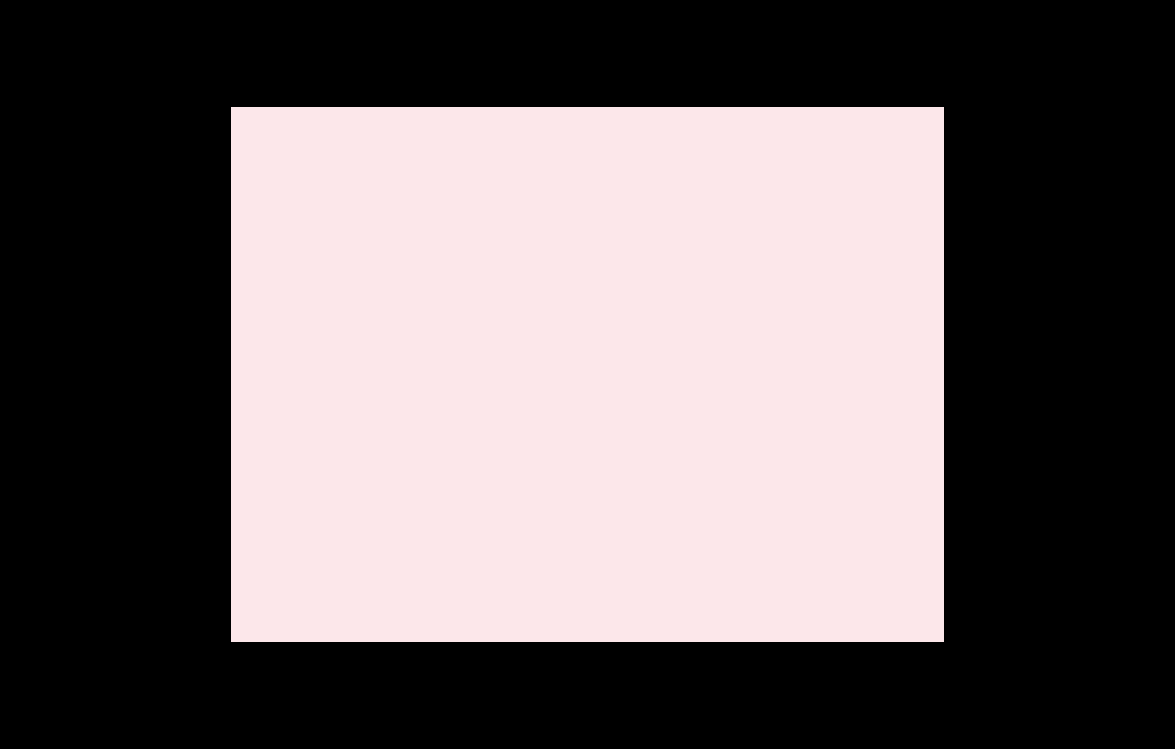

In [9]:
pink_h_hsv = np.zeros_like(pink_hsv)
pink_h_mean = pink_hsv[:, :, 0].mean()
pink_s_mean = pink_hsv[:, :, 1].mean()
pink_v_mean = pink_hsv[:, :, 2].mean()
print(f'{pink_h_mean=}')
print(f'{pink_s_mean=}')
print(f'{pink_v_mean=}')
pink_h_hsv[:, :, 0] = pink_h_mean
pink_h_hsv[:, :, 1] = pink_s_mean
pink_h_hsv[:, :, 2] = pink_v_mean

pink_h_rgb = color.hsv2rgb(pink_h_hsv)
pink_h_rgb = util.img_as_ubyte(pink_h_rgb)
print(f'{pink_h_rgb.dtype=}')

viewer.add_image(pink_h_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Load first frame of video

vid_frame.shape=(1920, 1080, 3)
vid_frame.dtype=dtype('uint8')


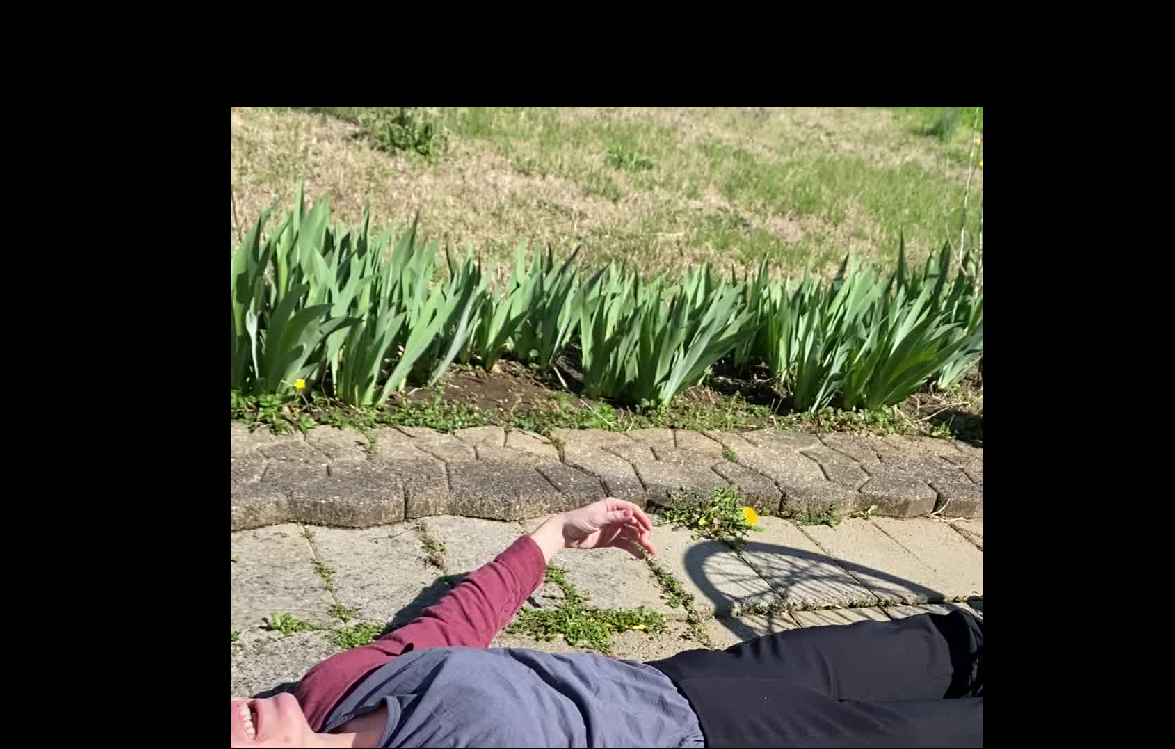

In [10]:
vid_frame_path = Path(project_dir / 'videos/mc-laying/frames/mc-laying-001.jpg')
vid_frame = iio.imread(vid_frame_path)
print(f'{vid_frame.shape=}')
print(f'{vid_frame.dtype=}')
viewer.add_image(vid_frame)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Rescale image

pink_img.shape=(768, 1024, 3)
vid_frame.shape=(1920, 1080, 3)
vid_frame_resized.shape=(768, 432, 3)


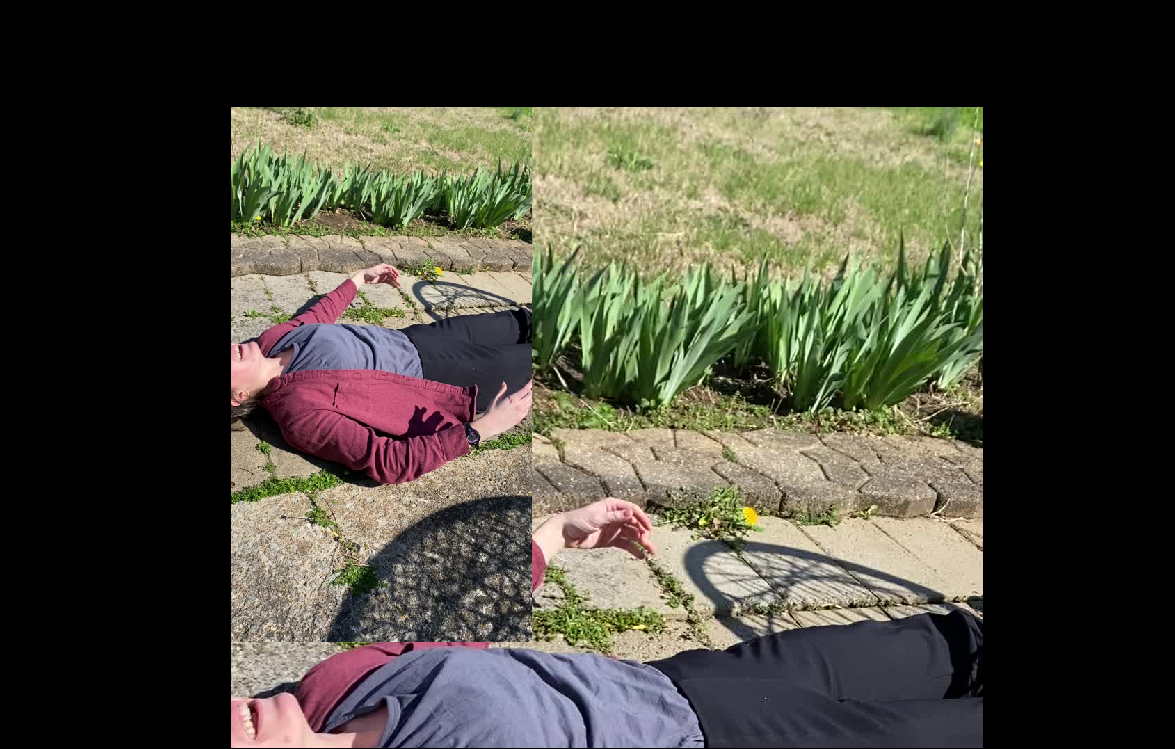

In [11]:
print(f'{pink_img.shape=}')
print(f'{vid_frame.shape=}')
vid_frame_resized = transform.resize(
    vid_frame, 
    (pink_img.shape[0], vid_frame.shape[1] * pink_img.shape[0] / vid_frame.shape[0]), 
    anti_aliasing=True
)
print(f'{vid_frame_resized.shape=}')
viewer.add_image(vid_frame_resized)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Extract frame hue

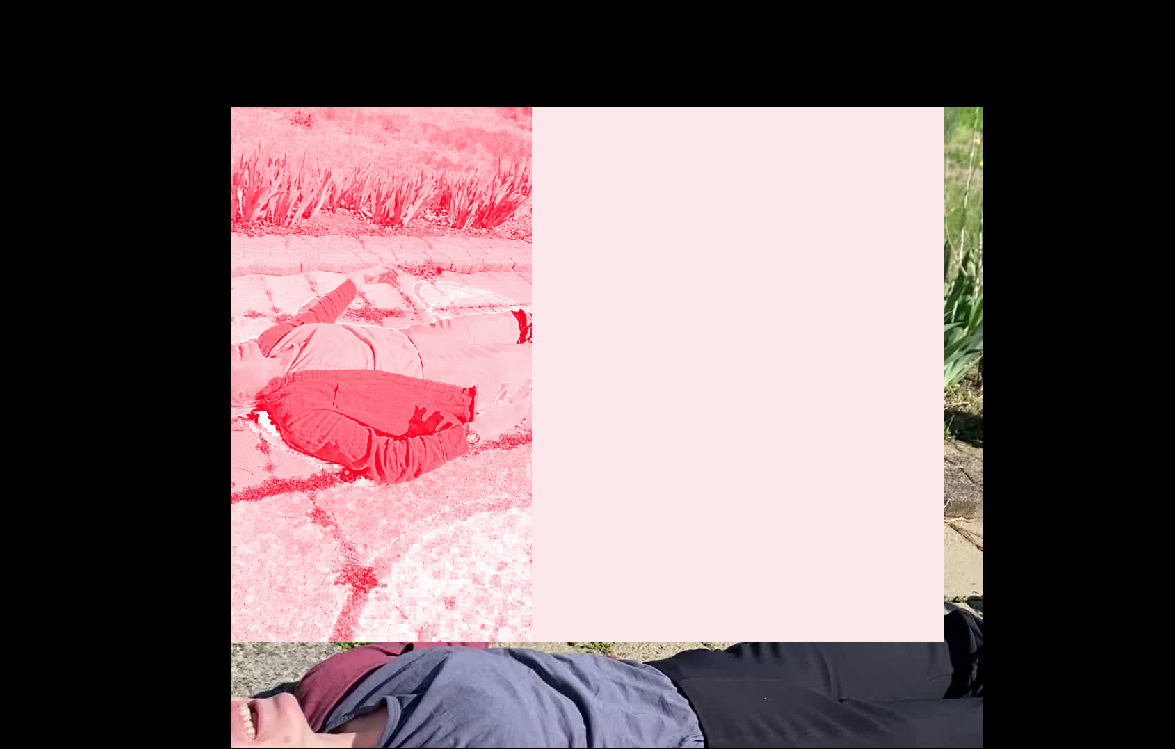

In [12]:
vid_frame_resized_hsv = color.rgb2hsv(vid_frame_resized)
pinkified_hsv = pink_hsv.copy()
pinkified_hsv[:, :vid_frame_resized_hsv.shape[1], 1] = vid_frame_resized_hsv[:, :, 1]
pinkified_rgb = color.hsv2rgb(pinkified_hsv)
viewer.add_image(pinkified_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

In [13]:
def plot_hist(img, chan=None, xlims=(0, 1), cumul=False, vlines=None):

    fig, ax = plt.subplots()
    if len(img.shape) == 2:
        ax.hist(img.ravel())
    elif chan is not None:
        ax.hist(img[:, :, chan].ravel(), bins=256, cumulative=cumul)
    else:
        for chan in range(3):
            ax.hist(img[:, :, chan].ravel(), bins=256)
    ax.set_xlim(xlims[0], xlims[1])

    if vlines is not None:
        try:
            iter(vlines)
        except TypeError:
            vlines = [vlines]
        for v in vlines:
            ax.axvline(v, color='r')

    return fig, ax

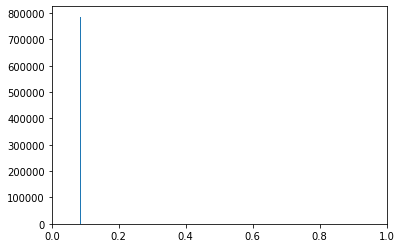

In [14]:
fig, ax = plot_hist(pink_hsv, chan=1)
plt.show()

pink_s_mean=0.08333333333333325


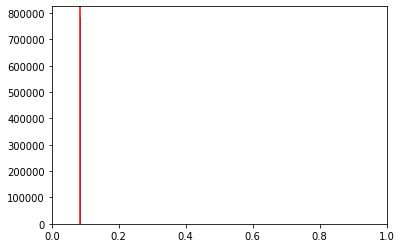

In [15]:
pink_s_mean = pink_hsv[:, :, 1].mean()
print(f'{pink_s_mean=}')
fig, ax = plot_hist(pink_hsv, chan=1, vlines=pink_s_mean)
plt.show()

## Rescale saturation intensity closer to the mean

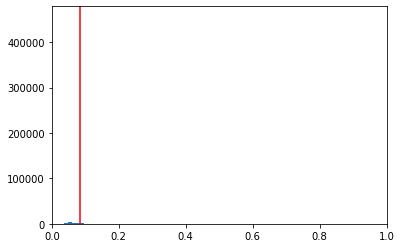

In [16]:
pinkified_s_rescaled_hsv = pinkified_hsv.copy()
pinkified_s_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
    pinkified_hsv[:, :, 1], out_range=(pink_s_mean - 0.05, pink_s_mean + 0.05)
)
fig, ax = plot_hist(pinkified_s_rescaled_hsv, chan=1, vlines=pink_s_mean)
plt.show()

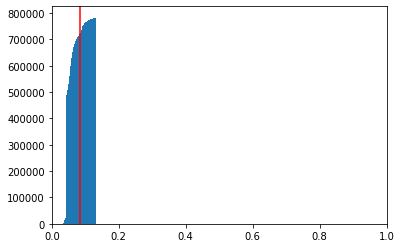

In [17]:
pinkified_s_rescaled_hsv = pinkified_hsv.copy()
pinkified_s_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
    pinkified_hsv[:, :, 1], out_range=(pink_s_mean - 0.05, pink_s_mean + 0.05)
)
fig, ax = plot_hist(pinkified_s_rescaled_hsv, chan=1, cumul=True, vlines=pink_s_mean)
plt.show()

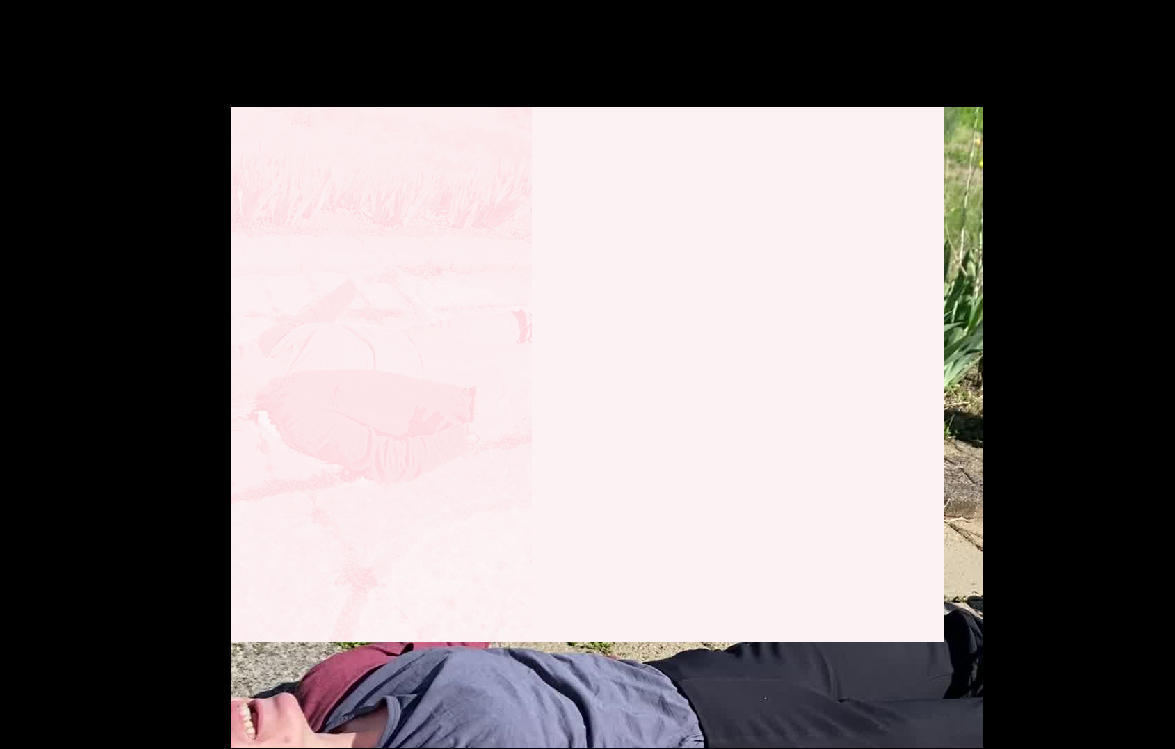

In [18]:
pinkified_s_rescaled_rgb = color.hsv2rgb(pinkified_s_rescaled_hsv)
viewer.add_image(pinkified_s_rescaled_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

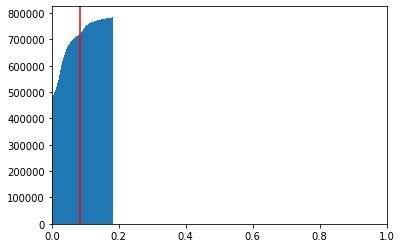

In [19]:
pinkified_s_rescaled_hsv = pinkified_hsv.copy()
pinkified_s_rescaled_hsv[:, :, 1] = exposure.rescale_intensity(
    pinkified_hsv[:, :, 1], out_range=(pink_s_mean - 0.1, pink_s_mean + 0.1)
)
fig, ax = plot_hist(pinkified_s_rescaled_hsv, chan=1, cumul=True, vlines=pink_s_mean)
plt.show()

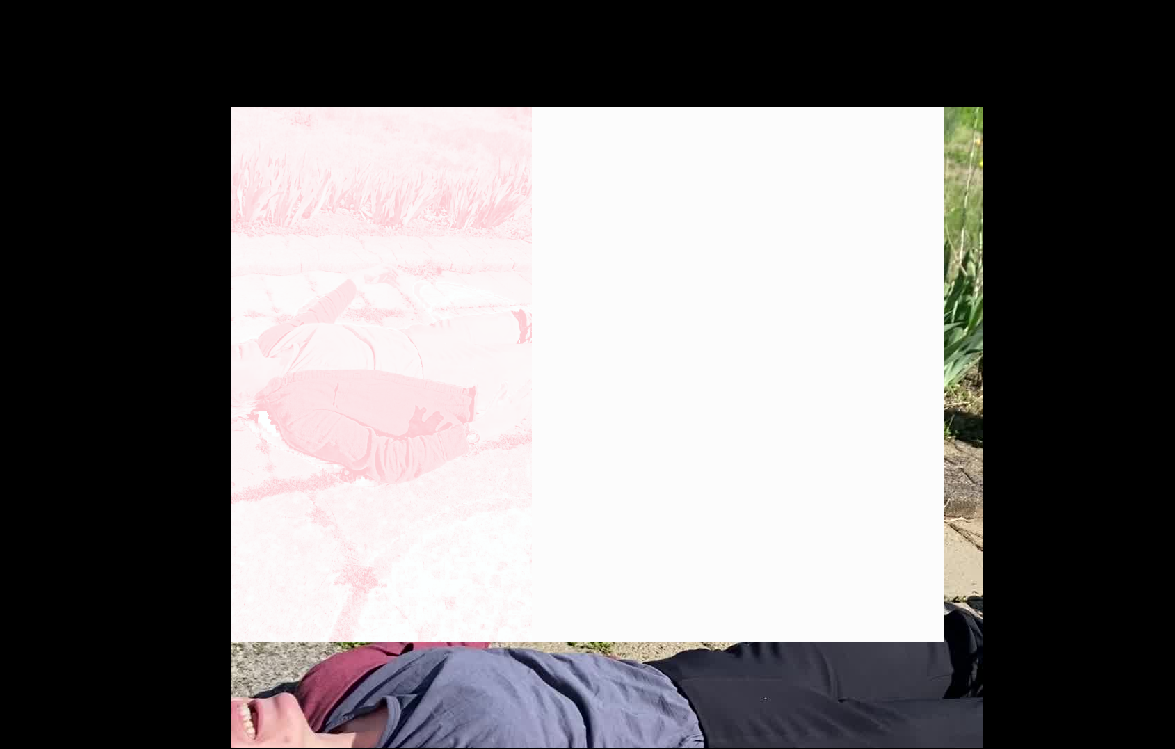

In [20]:
pinkified_s_rescaled_rgb = color.hsv2rgb(pinkified_s_rescaled_hsv)
viewer.add_image(pinkified_s_rescaled_rgb)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Pinkify all images in directory

0.31765485281835903


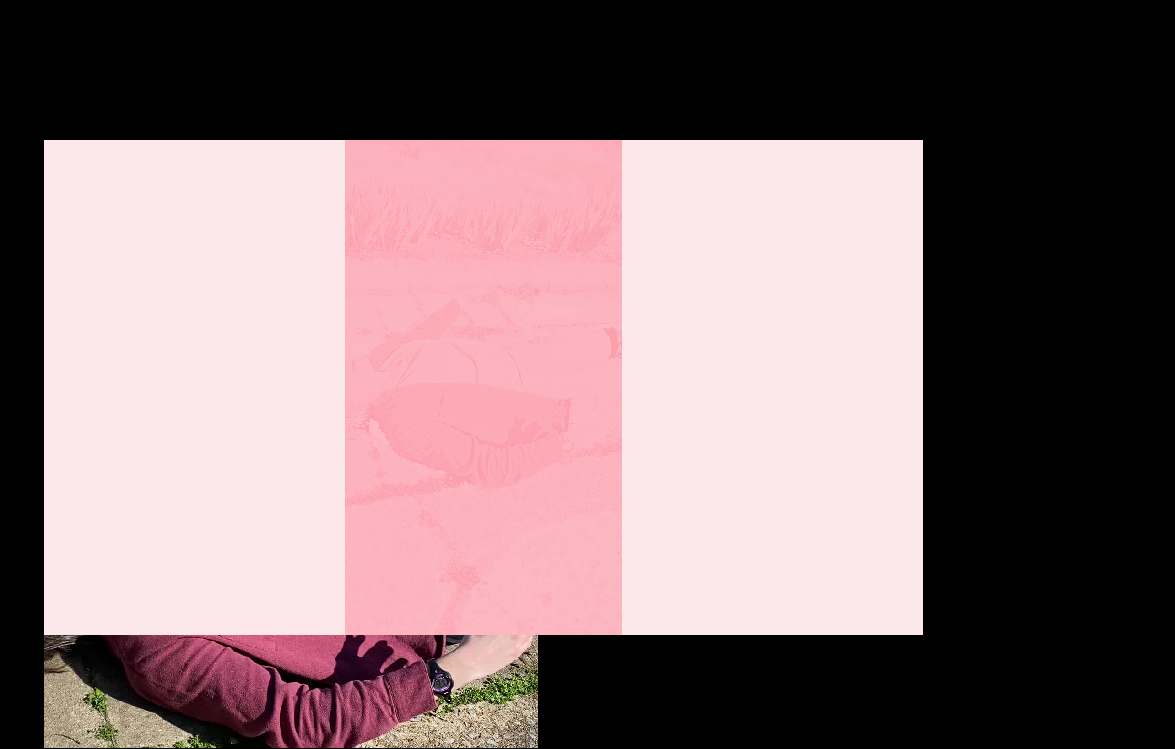

In [42]:
def pinkify_dir(
    img_dir, col_offset='center', canvas_size=(1080, 1920, 3), sat_spread=0.05, 
    img_suffix='.jpg'
):
    pink_imgs = []
    img_dir = Path(img_dir)
    img_paths = [path for path in img_dir.glob(f'*{img_suffix}')]
    # for img_path in img_paths:
    # Load and resize image
    img_path = img_paths[0]
    img = iio.imread(img_path)
    img_resized = helpers.resize_by_nrows(img, canvas_size[0])
    nrows, ncols, nchans = img_resized.shape
    # Pinkify image
    pink_rgb = helpers.pink_like(img_resized)
    pink_hsv = color.rgb2hsv(pink_rgb)
    img_hsv = color.rgb2hsv(img_resized)
    pink_hsv[:, :, 1] = img_hsv[:, :, 1]
    # Rescale saturation to +/- sat spread around mean
    pink_s_mean = pink_hsv[:, :, 1].mean()
    print(pink_s_mean)
    pink_hsv[:, :, 1] = exposure.rescale_intensity(
        pink_hsv[:, :, 1], 
        out_range=(pink_s_mean - sat_spread, pink_s_mean + sat_spread)
    )
    # Make pink canvas
    canvas = helpers.pink(canvas_size)
    canvas_hsv = color.rgb2hsv(canvas)
    # Add pink image to part of pink canvas
    if col_offset == 'center':
        col_offset = canvas_size[1] // 2 - (ncols // 2) 
    canvas_hsv[:, col_offset:col_offset + ncols, :] = pink_hsv
    canvas_rgb = color.hsv2rgb(canvas_hsv)
    return canvas_rgb
    # return np.array(pink_imgs)
vid_frames_dir = Path(project_dir / 'videos/mc-laying/frames/')
vid_frames_dir.exists()
pink_imgs = pinkify_dir(vid_frames_dir)
viewer.add_image(pink_imgs)
napari.utils.nbscreenshot(viewer, canvas_only=True)